## Purpose: create a training set of sources with labels



In [1]:
import splat
import wisps
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
#sf0=pd.read_pickle(wisps.OUTPUT_FILES+'/selection_function.pkl')

In [3]:
from wisps import datasets

In [4]:
highsnr=(datasets['highsnr']).reset_index(drop=True)
lowsnr=(datasets['lowsnr']).reset_index(drop=True)

In [5]:
merged=pd.concat([highsnr, lowsnr])
mergeds=merged.iloc[(merged[wisps.INDEX_NAMES]).dropna().index]

In [6]:
stars=mergeds

In [7]:
mergeds.columns

Index(['snr1', 'snr2', 'snr3', 'snr4', 'H_2O-1/J-Cont', 'H_2O-2/H_2O-1',
       'H-cont/H_2O-1', 'CH_4/H_2O-1', 'H_2O-2/J-Cont', 'H-cont/J-Cont',
       'CH_4/J-Cont', 'H-cont/H_2O-2', 'CH_4/H_2O-2', 'CH_4/H-Cont',
       'H_2O-1+H_2O-2/J-Cont', 'H_2O-1+H_2O-2/H-Cont', 'H_2O-1+CH_4/J-Cont',
       'H_2O-2+CH_4/J-Cont', 'H_2O-1+CH_4/H-Cont', 'H_2O-2+CH_4/H-Cont',
       'grism_id', 'f_test', 'line_chi', 'spex_chi', 'spt_new', 'spt'],
      dtype='object')

In [8]:
#mergeds.to_hdf(wisps.COMBINED_PHOTO_SPECTRO_FILE, key='new_stars')

In [9]:
stars.grism_id=stars.grism_id.apply(lambda x: str(x).lower())

In [10]:
trash_names=trash=pd.read_pickle(wisps.OUTPUT_FILES+'/trash.pkl').grism_id

In [11]:
trash=stars[stars.grism_id.isin(trash_names)]

In [12]:
trash['label']=0.

In [13]:
spex=datasets['spex']

In [14]:
spex['grism_id']=spex.data_file

In [15]:
man=(datasets['manjavacas']).rename(columns={'f':'f_test'})
schn=(datasets['schneider']).rename(columns={'f':'f_test'})

In [16]:
#sf=pd.DataFrame.from_records(pd.DataFrame(sf0).values.flatten()).sample(n=10000)

In [17]:
#sf['spt']=sf['spt_new']

In [18]:
spex['spt']=spex.spt.apply(wisps.make_spt_number)
man['spt']=man.spt.apply(wisps.make_spt_number)
schn['spt']=schn.spt.apply(wisps.make_spt_number)
trash['spt']=trash.spt.apply(wisps.make_spt_number)
#sf['spt']=sf.spt.apply(wisps.make_spt_number)
spex['name']=spex['grism_id']

In [19]:
cand_ids=pd.read_pickle(wisps.OUTPUT_FILES+'/true_spectra_cands.pkl')
cand_ids['grism_id']=cand_ids.spectra.apply(lambda x: x.grism_id.lower())

In [20]:
stars=wisps.datasets['stars']
cands=(stars[stars.grism_id.isin(cand_ids.grism_id)]).reset_index(drop=True)

In [21]:
cands['label']=1
cands['spt']=cands.spt.apply(wisps.make_spt_number)

In [22]:
features =np.concatenate([wisps.INDEX_NAMES, ['spex_chi', 'snr2', 'snr1', 'snr3','snr4',
       'line_chi', 'label', 'f_test', 'spt', 'snr1']])

In [23]:
from scipy import stats

In [24]:
def f_test_comp(x):
    return stats.f.cdf(x, 2, 1, 0, scale=1)

man['x']=man.spex_chi/man.line_chi
schn['x']=schn.spex_chi/schn.line_chi
man['f_test']=man.x.apply(f_test_comp)
schn['f_test']=schn.x.apply(f_test_comp)
spex['f_test']=(spex.spex_chi/spex.line_chi).apply(f_test_comp)
#sf['f_test']=(sf.spex_chi/sf.line_chi).apply(f_test_comp)

In [25]:
#sf.columns

In [26]:
trash['name']=trash.grism_id
#sf['name']=['spc {}'+str(i) for i in sf.index]

In [27]:
feats=[x for x in features if x not in ['name']]

In [28]:
def add_binary_label(row):
    label=0.
    if (row.spt >=15):
        label=1.
    else:
        label=0.0
    return label

In [29]:
trash['label']=0.
spex['label']=spex.apply(add_binary_label, axis=1)
schn['label']=schn.apply(add_binary_label, axis=1)
#sf['label']=schn.apply(add_binary_label, axis=1)
man['label']=man.apply(add_binary_label, axis=1)

In [30]:
spex=spex.iloc[(spex[wisps.INDEX_NAMES]).dropna().index]
man=man.iloc[(man[wisps.INDEX_NAMES]).dropna().index]
schn=schn.iloc[(schn[wisps.INDEX_NAMES]).dropna().index]

In [31]:
spex=wisps.Annotator.reformat_table(spex)
trash=wisps.Annotator.reformat_table(trash)
schn=wisps.Annotator.reformat_table(schn)
man=wisps.Annotator.reformat_table(man)
#sf=wisps.Annotator.reformat_table(sf)

In [32]:
training_set=pd.concat( [ spex[features], trash[features], man[features], schn[features]]).reset_index(drop=True)

In [33]:
training_set.shape

(9728, 26)

In [34]:
training_set=(training_set[features]).dropna(how='all').reset_index(drop=True)

In [35]:
training_set['lablel']=training_set.apply(add_binary_label, axis=1)

In [36]:
final_set=training_set

In [37]:
#final_set=pd.concat([label0, label1]).reset_index(drop=True)

In [38]:
final_set=final_set.reset_index(drop=True).applymap(float)

In [39]:
final_set = final_set.loc[:,~final_set.columns.duplicated()]

In [40]:
final_set.to_pickle(wisps.LIBRARIES+'/training_set.pkl')

(-1, 4)

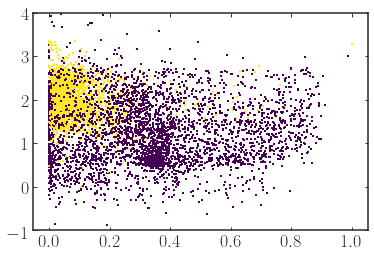

In [41]:
plt.scatter(final_set['f_test'], final_set['snr1'].apply(np.log10), c=final_set['label'], s=4, marker='+' , cmap='viridis')
plt.ylim([-1, 4])

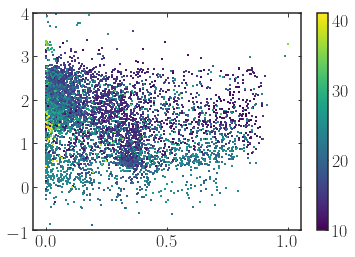

In [42]:
plt.scatter(final_set['f_test'], final_set['snr1'].apply(np.log10), c=final_set['spt'], s=4, marker='+' , cmap='viridis')
plt.ylim([-1, 4])
plt.colorbar()